# Random Forests

In [ ]:
# load packages
import sklearn
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
# set max display of rows to 100
pd.set_option('display.max_rows', 100)

# show all columns
pd.set_option('max_columns', None)

### 1. Read in the data

In [ ]:
# read in diabetes data
cardio_updated = pd.read_csv('cardio_updated.csv')

In [ ]:
# rename cardio to label
cardio_updated.rename(columns={'cardio':'label'}, inplace=True)

In [ ]:
# drop age
cardio_updated.drop(columns={'age'}, inplace=True)

In [ ]:
# print out data
cardio_updated.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,label,age_year,bmi
0,0,168,62.0,110,80,1,1,0,0,1,0,50,21.967120
1,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679
2,1,165,64.0,130,70,3,1,0,0,0,1,51,23.507805
3,0,169,82.0,150,100,1,1,0,0,1,1,48,28.710479
4,1,156,56.0,100,60,1,1,0,0,0,0,47,23.011177


In [ ]:
# check dimensions of the data
cardio_updated.shape

(66801, 13)

### 2. Split the data

In [ ]:
# split data into train / validation
train_data, val_data = train_test_split(cardio_updated, train_size = 0.7, random_state = 0)

In [ ]:
# look at counts of the label
train_data.label.value_counts()

0    23815
1    22945
Name: label, dtype: int64

In [ ]:
# split the label out from the train and validation sets
y_train = train_data.label
x_train = train_data.drop(columns = ["label"])

y_val = val_data.label
x_val = val_data.drop(columns = ["label"])

### 3. Train the Random Forest Model

In [ ]:
# train random forest model without any hyperparameter tuning
start = time.time()
forest_model = RandomForestClassifier(n_estimators = 200, max_depth = 3, 
                                      min_samples_split = 50, min_samples_leaf = 10,
                                      max_samples = 0.2, random_state = 0).fit(x_train, y_train)
end = time.time()
print("Total time in seconds ==> ", end - start)

Total time in seconds ==>  1.1445796489715576


In [ ]:
# feature importances
forest_model.feature_importances_

array([4.22660584e-04, 1.04396548e-03, 2.14514785e-02, 4.19837746e-01,
       2.78120358e-01, 1.04939158e-01, 7.04150184e-03, 3.28666476e-04,
       1.71499141e-04, 1.60678847e-03, 1.08915105e-01, 5.61210727e-02])

In [ ]:
# Print a dictionary that maps each feature to its importance level
{var : imp for var, imp in zip(x_train.columns, forest_model.feature_importances_)}

{'gender': 0.00042266058378028713,
 'height': 0.0010439654791988176,
 'weight': 0.021451478485657316,
 'ap_hi': 0.41983774555769693,
 'ap_lo': 0.27812035819203695,
 'cholesterol': 0.10493915815427356,
 'gluc': 0.007041501840391218,
 'smoke': 0.00032866647632428386,
 'alco': 0.0001714991411151179,
 'active': 0.0016067884699125453,
 'age_year': 0.1089151048717666,
 'bmi': 0.056121072747846494}

In [ ]:
## Create a data frame with the feature importances
###################################################
# First create an empty data frame
imp = pd.DataFrame()

# add a column for the variable names
imp["var"] = x_train.columns

# add a column with the feature importances
imp["imp"] = forest_model.feature_importances_

# sort the data frame by the feature importances in descending order - most important features at the top
imp = imp.sort_values("imp", ascending = False).reset_index(drop = True)

# print out the data frame
imp

,var,imp
0,ap_hi,0.419838
1,ap_lo,0.278120
2,age_year,0.108915
3,cholesterol,0.104939
4,bmi,0.056121
5,weight,0.021451
6,gluc,0.007042
7,active,0.001607
8,height,0.001044
9,gender,0.000423


In [ ]:
# test training data predicted probabilties 
y_train_prob = forest_model.predict_proba(x_train)
y_train_prob

array([[0.65144454, 0.34855546],
       [0.32344482, 0.67655518],
       [0.66121735, 0.33878265],
       ...,
       [0.22785571, 0.77214429],
       [0.61795516, 0.38204484],
       [0.65221389, 0.34778611]])

In [ ]:
# get validation data predicted probabilities
y_val_prob = forest_model.predict_proba(x_val)
y_val_prob

array([[0.61947962, 0.38052038],
       [0.59158419, 0.40841581],
       [0.6628753 , 0.3371247 ],
       ...,
       [0.57681781, 0.42318219],
       [0.68362221, 0.31637779],
       [0.22737721, 0.77262279]])

In [ ]:
# AUC on training set
fpr, tpr, thresholds = metrics.roc_curve(train_data.label, y_train_prob[:,1], pos_label = 1)
metrics.auc(fpr, tpr)

0.7890831277470379

In [ ]:
# AUC on validation set
fpr, tpr, thresholds = metrics.roc_curve(val_data.label, y_val_prob[:,1], pos_label = 1)
metrics.auc(fpr, tpr)

0.7866080873399302

### 4. Hyperparameter tuning with a Random Forest

In [ ]:
parameters = {"max_depth":range(2, 8), "min_samples_leaf": range(5, 55, 5), "min_samples_split": range(10, 110, 5),
              "max_samples":[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4], "max_features": [2, 3, 4, 5, 6],
              "n_estimators": [100, 150, 200, 250, 300, 350, 400]}

start = time.time()
clf = RandomizedSearchCV(RandomForestClassifier(), parameters, n_jobs=6, scoring = "roc_auc", n_iter = 200,
                        random_state = 0)
clf.fit(x_train, y_train)
end = time.time()
print("Total time in seconds ==> ", end - start)

Total time in seconds ==>  467.73078989982605


In [ ]:
# print the optimized parameters from those tested
clf.best_params_

{'n_estimators': 300,
 'min_samples_split': 70,
 'min_samples_leaf': 30,
 'max_samples': 0.35,
 'max_features': 6,
 'max_depth': 7}

In [ ]:
## Create a data frame with the feature importances
###################################################
# First create an empty data frame
imp = pd.DataFrame()

# add a column for the variable names
imp["var"] = x_train.columns

# add a column with the feature importances
imp["imp"] = clf.best_estimator_.feature_importances_

# sort the data frame by the feature importances in descending order - most important features at the top
imp = imp.sort_values("imp", ascending = False).reset_index(drop = True)

# print out the data frame
imp

,var,imp
0,ap_hi,0.555829
1,ap_lo,0.163096
2,age_year,0.127071
3,cholesterol,0.083080
4,bmi,0.030142
5,weight,0.017646
6,height,0.009094
7,gluc,0.006009
8,active,0.004901
9,gender,0.001356


In [ ]:
# Get the predicted probabilities on the training set
y_train_prob = clf.predict_proba(x_train)
y_train_prob

array([[0.77710283, 0.22289717],
       [0.15856684, 0.84143316],
       [0.7410613 , 0.2589387 ],
       ...,
       [0.15694448, 0.84305552],
       [0.64640508, 0.35359492],
       [0.70909282, 0.29090718]])

In [ ]:
# Get the validation probabilities
y_val_prob = clf.predict_proba(x_val)
y_val_prob

array([[0.7071492 , 0.2928508 ],
       [0.60782663, 0.39217337],
       [0.79560403, 0.20439597],
       ...,
       [0.60916005, 0.39083995],
       [0.83296064, 0.16703936],
       [0.17036301, 0.82963699]])

In [ ]:
# calculate AUC on the training set using the optimized random forest model
fpr, tpr, thresholds = metrics.roc_curve(train_data.label, y_train_prob[:,1], pos_label = 1)
metrics.auc(fpr, tpr)

0.8068314745660362

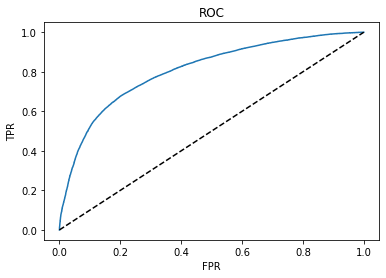

In [ ]:
# Plot ROC on training dataset
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot([0, 1], [0, 1], color = 'black', linestyle = "dashed")
plt.title("ROC")
plt.show()

In [ ]:
# Get the AUC on the validation set
fpr, tpr, thresholds = metrics.roc_curve(val_data.label, y_val_prob[:,1], pos_label = 1)
metrics.auc(fpr, tpr)

0.7982673139775963

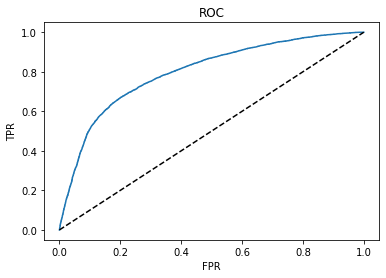

In [ ]:
# Plot ROC on validation dataset
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot([0, 1], [0, 1], color = 'black', linestyle = "dashed")
plt.title("ROC")
plt.show()

In [ ]:
# look at all the combinations of parameters tested
clf.cv_results_["params"]

[{'n_estimators': 200,
  'min_samples_split': 60,
  'min_samples_leaf': 15,
  'max_samples': 0.1,
  'max_features': 4,
  'max_depth': 4},
 {'n_estimators': 200,
  'min_samples_split': 105,
  'min_samples_leaf': 40,
  'max_samples': 0.25,
  'max_features': 2,
  'max_depth': 5},
 {'n_estimators': 200,
  'min_samples_split': 65,
  'min_samples_leaf': 30,
  'max_samples': 0.25,
  'max_features': 4,
  'max_depth': 4},
 {'n_estimators': 300,
  'min_samples_split': 45,
  'min_samples_leaf': 35,
  'max_samples': 0.35,
  'max_features': 5,
  'max_depth': 3},
 {'n_estimators': 250,
  'min_samples_split': 10,
  'min_samples_leaf': 10,
  'max_samples': 0.3,
  'max_features': 3,
  'max_depth': 6},
 {'n_estimators': 150,
  'min_samples_split': 65,
  'min_samples_leaf': 25,
  'max_samples': 0.3,
  'max_features': 3,
  'max_depth': 6},
 {'n_estimators': 150,
  'min_samples_split': 55,
  'min_samples_leaf': 45,
  'max_samples': 0.2,
  'max_features': 4,
  'max_depth': 5},
 {'n_estimators': 150,
  'min_

### 5. Accuracy, Precision, Recall, F1-Score

In [ ]:
thresh = np.arange(0.01, 1, .01) 

precision_values = []
recall_values = []
acc_values = []
f1_values = []

for val in thresh:
    
    pred = [1 if prob >= val else 0 for prob in y_train_prob[:,1]]
    
    precision = metrics.precision_score(y_train, pred)
    recall = metrics.recall_score(y_train, pred)
    accuracy = metrics.accuracy_score(y_train, pred)
    f1_score = metrics.f1_score(y_train, pred)
    
    precision_values.append(precision)
    recall_values.append(recall)
    acc_values.append(accuracy)
    f1_values.append(f1_score)

result = pd.DataFrame()
result["threshold"] = thresh
result["precision"] = precision_values
result["recall"] = recall_values
result["accuracy"] = acc_values
result["f1_score"] = f1_values

result

D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,threshold,precision,recall,accuracy,f1_score
0,0.01,0.490697,1.000000,0.490697,0.658346
1,0.02,0.490697,1.000000,0.490697,0.658346
2,0.03,0.490697,1.000000,0.490697,0.658346
3,0.04,0.490697,1.000000,0.490697,0.658346
4,0.05,0.490697,1.000000,0.490697,0.658346
5,0.06,0.490729,1.000000,0.490761,0.658374
6,0.07,0.491233,1.000000,0.491788,0.658828
7,0.08,0.492445,0.999913,0.494247,0.659898
8,0.09,0.493767,0.999433,0.496920,0.660979
9,0.10,0.494873,0.998998,0.499145,0.661873


In [ ]:
# Pick threshold based off optimal F1-Score on training set
result.iloc[result.f1_score.idxmax()]

threshold    0.360000
precision    0.665452
recall       0.827457
accuracy     0.711206
f1_score     0.737664
Name: 35, dtype: float64

Text(0.5, 1.0, 'Confusion matrix of the training set')

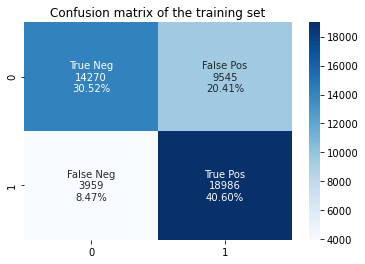

In [ ]:
train_yhat = [1 if i >= 0.36 else 0 for i in clf.predict_proba(x_train)[:,1]]
train_confusion_matrix = metrics.confusion_matrix(y_train, train_yhat) 
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                train_confusion_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     train_confusion_matrix.flatten()/np.sum(train_confusion_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(train_confusion_matrix, annot=labels, fmt='', cmap='Blues').set_title('Confusion matrix of the training set')

In [ ]:
## Use above threshold to calculate accuracy, precision, recall, and F1-score on validation set

# get 1 / 0 predictions based off probability threshold
pred = [1 if prob >= 0.36 else 0 for prob in y_val_prob[:,1]]

# calculate precision, recall, accuracy, and f1-score
precision = metrics.precision_score(y_val, pred)
recall = metrics.recall_score(y_val, pred)
accuracy = metrics.accuracy_score(y_val, pred)
f1_score = metrics.f1_score(y_val, pred)

print("Validation precision: ", precision)
print("Validation recall: ", recall)
print("Validation accuracy: ", accuracy)
print("Validation F1-Score: ", f1_score)


Validation precision:  0.6558143349188126
Validation recall:  0.8214689265536723
Validation accuracy:  0.7038570929594332
Validation F1-Score:  0.7293538237037713


Text(0.5, 1.0, 'Confusion matrix of the validation set')

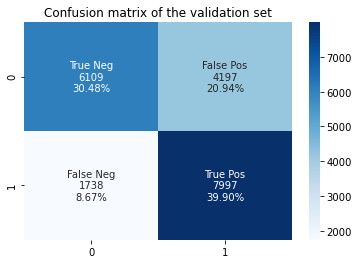

In [ ]:
## confusion matrix for the validation set when proba threshold is 0.35
val_yhat = [1 if i >= 0.36 else 0 for i in clf.predict_proba(x_val)[:,1]]
val_confusion_matrix = metrics.confusion_matrix(y_val, val_yhat)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                val_confusion_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     val_confusion_matrix.flatten()/np.sum(val_confusion_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(val_confusion_matrix, annot=labels, fmt='', cmap='Blues').set_title('Confusion matrix of the validation set')
